## Project 1

The goal of the first project is to do some wrangling, EDA, and visualization, and generate sequences of values. We will focus on:

- CDC National Health and Nutritional Examination Survey (NHANES, 1999-2000): https://wwwn.cdc.gov/nchs/nhanes/continuousnhanes/default.aspx?BeginYear=1999
- CDC Linked Mortality File (LMF, 1999-2000): https://www.cdc.gov/nchs/data-linkage/mortality-public.htm

NHANES is a rich panel dataset on health and behavior, collected bi-yearly from around 1999 to now. We will focus on the 1999 wave, because that has the largest follow-up window, providing us with the richest mortality data. The mortality data is provided by the CDC Linked Mortality File.

The purpose of the project is to use $k$-NN to predict who dies (hard or soft classification) and how long they live (regression).

### Part 1: Wrangling and EDA (40/100 pts)

First, go to the NHANES and LMF web sites and familiarize yourself with the data sources. Download codebooks. Think about what resources are available. The CDC Linked Mortality File is somewhat of a pain to work with, so I have pre-cleaned it for you. It is available at httts://github.com/ds4e/undergraduate_ml_assignments in the data folder, as `lmf_parsed.cav`. From the CDC LMF web page, get the SAS program to load the data; it is the real codebook.

Second, download the demographic data for the 1999--2000 wave from the NHANES page. You can use the following code chunk to merge the LMF and DEMO data:

``` python
import pandas as pd
mdf = pd.read_csv('linked_mortality_file_1999_2000.csv') # Load mortality file
print( mdf.head() )
gdf = pd.read_sas("DEMO.xpt", format="xport") # Load demographics file
print( gdf.head() )
df = gdf.merge(mdf, on="SEQN", how="inner") # Merge mortality and demographics on SEQN variable
```

Third, the variables `ELIGSTAT`, `MORTSTAT`, `PERMTH_INT`, and `RIDAGEEX` are particularly important. Look them up in the documentation and clearly describe them. (5/100 pts.)

Second, the goal of the project is to use whatever demographic, behavioral, and health data you like to predict mortality (`MORTSTAT`) and life expectancy (`PERMTH_INT`). Go to the NHANES 1999--2000 web page and select your data and download it. Clearly explain your rationale for selecting these data. Use `.merge` to combine your data into one complete dataframe. Document missing values. (5/100 pts)

Third, do basic EDA and visualization of the key variables. Are any important variables skewed? Are there outliers? How correlated are pairs of variables? Do pairs of categorical variables exhibit interesting patterns in contingency tables? Provide a clear discussion and examination of the data and the variables you are interested in using. (20/100 pts)


### Part 2: $k$-NN classification/regression, write-up (50/100 pts)

Submit a notebook that clearly addresses the following, using code and markdown chunks:

1. Describe the data, particularly what an observation is and whether there are any missing data that might impact your analysis. Who collected the data and why? What known limitations are there to analysis? (10/100 pts)
2. Describe the variables you selected to predict mortality and life expectancy, and the rationale behind them. Analyze your variables using describe tables, kernel densities, scatter plots, and conditional kernel densities. Are there any patterns of interest to notice? (10/100 pts)
3. Using your variables to predict mortality using a $k$-Nearest Neighbor Classifier. Analyze its performance and explain clearly how you select $k$. (10/100 pts)
4. Using your variables to predict life expectancy using a $k$-Nearest Neighbor Regressor. Analyze its performance and explain clearly how you select $k$. (10/100 pts)
5. Describe how your model could be used for health interventions based on patient characteristics. Are there any limitations or risks to consider? (10/100 pts)

## Submission (10/100 pts)

Submit your work in a well-organized GitHub repo, where the code is appropriately commented and all members of the group have made significant contributions to the commit history. (10/100 pts)

**INITIAL DATA MERGING**

In [13]:
import pandas as pd
mdf = pd.read_csv('linked_mortality_file_1999_2000.csv') # Load mortality file
gdf = pd.read_sas("DEMO.xpt", format="xport") # Load demographics file
df = gdf.merge(mdf, on="SEQN", how="inner") # Merge mortality and demographics on SEQN variable

**VARIABLES AND DESCRIPTIONS**



**ELIGSTAT:** Eligibility Status for Mortality (Follow up)
Essentially, this variable tells us whether a person in the survey provided enough information to actually track if they are still alive or have passed away
**Range of Values:** 1(Eligible ), 2(Under age 18, not available for public release),3(Ineligible)


**MORTSTAT:** Final Mortality Status
Tells us the final known death status of the participant at the end of the follow-up period.
**Range of Values:** 0(Assumed alive), 1(Assumed deceased),.(Ineligible or under age 18)


**PERMTH_INT:** Number of Person Months of Follow-up from NHANES interview
date
It tells us exactly how many months a person was "in the study" before the record ended, either because they passed away or because the study reached its cutoff date.
**Range of Values:** 0-374(months) or .(Ineligible or under age 18)


**RIDAGEEX:**
This variable tells us exactly how many months old they were when they actually went to the clinic for their physical exam.
**Range of Values:** 0-1020(months) or if a person was 1020 months or older during the initial interview, the CDC does not provide their age in months.






Source: https://www.cdc.gov/nchs/data/datalinkage/public-use-linked-mortality-files-data-dictionary.pdf


**JOINS BLOOD PRESSURE DATA SET AND HANDLES NULL/UNWANTED VALUES**

**MOTIVATION:** The reason for choosing this variable of interest is because cardio-vascular disease is the leading cause of death in America, and high blood pressure has been proven to increase risk of cardiovascular disease.

In [14]:

# Load the Blood Pressure Examination data
blood_pressure = pd.read_sas('BPX.xpt')


# Define the columns for each group
systolic_cols = ['BPXSY1', 'BPXSY2', 'BPXSY3']
diastolic_cols = ['BPXDI1', 'BPXDI2', 'BPXDI3']


# Calculate the row-wise mean
# skipna=True (default) ensures that if a person only has 2 readings,
# it averages those 2 rather than returning NaN.
blood_pressure['systolic_avg'] = blood_pressure[systolic_cols].mean(axis=1)
blood_pressure['diastolic_avg'] = blood_pressure[diastolic_cols].mean(axis=1)


# Merge blood pressure data set into original df
df = df.merge(blood_pressure, on="SEQN", how="inner")






# IMPORTANT STEP FOR MISSING VALUES: We found that only 3.62% of adult readings
# were N/A, so we decided to just keep adult readings and drop the remaining
#3.62% of the N/A's

# Filter the dataset to include only adults
df_adults = df[df['RIDAGEEX'] >= 216].copy()

# # Recalculate the percentage of missing values in the blood pressure columns
missing_systolic = df_adults['systolic_avg'].isna().mean() * 100
missing_diastolic = df_adults['diastolic_avg'].isna().mean() * 100

print(f"Missing Systolic (Adults): {missing_systolic:.2f}%")
print(f"Missing Diastolic (Adults): {missing_diastolic:.2f}%")

# Keep only adults (216 months = 18 years)
df_temp = df[df['RIDAGEEX'] >= 216].copy()

# Drop the remaining 3% of rows that have NaNs in BP averages
# This ensures your KNN analysis doesn't crash or encounter errors
df_bp_final = df_temp.dropna(subset=['systolic_avg', 'diastolic_avg'])



df_bp_final.head()



# NOTES:

# BPXSY1, BPXSY2, BPXSY3 (Systolic Blood Pressure): This is the "top number." Medically, elevated systolic pressure is a major risk factor for stroke and heart failure.

# BPXDI1, BPXDI2, BPXDI3 (Diastolic Blood Pressure): The "bottom number." Consistent elevation indicates high pressure in your arteries between heartbeats.

Missing Systolic (Adults): 3.62%
Missing Diastolic (Adults): 3.62%


,SEQN,SDDSRVYR,RIDSTATR,RIDEXMON,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDAGEEX,RIDRETH1,RIDRETH2,...,BPXSY3,BPXDI3,BPAEN3,BPXSY4,BPXDI4,BPAEN4,BPXSAR,BPXDAR,systolic_avg,diastolic_avg
1,2.0,1.0,2.0,2.0,1.0,77.0,926.0,926.0,3.0,1.0,...,98.0,56.0,2.0,NaN,NaN,NaN,98.0,56.0,100.666667,56.666667
4,5.0,1.0,2.0,2.0,1.0,49.0,597.0,597.0,3.0,1.0,...,122.0,82.0,2.0,NaN,NaN,NaN,122.0,83.0,122.000000,82.666667
5,6.0,1.0,2.0,2.0,2.0,19.0,230.0,230.0,5.0,4.0,...,112.0,80.0,2.0,NaN,NaN,NaN,114.0,70.0,114.666667,68.000000
6,7.0,1.0,2.0,2.0,2.0,59.0,712.0,712.0,4.0,2.0,...,124.0,82.0,2.0,NaN,NaN,NaN,123.0,81.0,125.333333,80.000000
9,10.0,1.0,2.0,2.0,1.0,43.0,518.0,518.0,4.0,2.0,...,142.0,96.0,2.0,NaN,NaN,NaN,142.0,95.0,145.333333,96.000000


Source: https://wwwn.cdc.gov/nchs/nhanes/search/datapage.aspx?Component=Examination&Cycle=1999-2000

**JOINS SMOKING DATA SET AND HANDLES NULL/UNWANTED VALUES**

**MOTIVATION:** Blood pressure can be heavily influenced by lifestyle factors, most notably tobacco use. Smoking acts as a significant catalyst for cardiovascular decline by causing immediate spikes in blood pressure and long-term arterial damage.

In [15]:
import numpy as np

# Load the Blood Pressure Examination data
smoking_status = pd.read_sas('SMQ.xpt')

df_bp_final = df_bp_final.merge(smoking_status, on="SEQN", how="inner")

df_bp_final.head()



import numpy as np

# Initial cleaning as per your current code
df_bp_final['SMD030'] = df_bp_final['SMD030'].replace([777, 999, 7777, 9999], np.nan)
df_bp_final['SMD030'] = df_bp_final['SMD030'].fillna(df_bp_final['SMD030'].median())

# Fill missing values with 0 for logic processing
cols_to_fix = ['SMD030', 'SMD055', 'SMD070']
df_bp_final[cols_to_fix] = df_bp_final[cols_to_fix].fillna(0)

def calculate_pack_years(row):
    # Logic for Never-Smokers
    if row['SMD030'] == 0:
        return 0, 0

    # Logic for Current Smokers (SMQ040 codes 1 or 2)
    # They haven't stopped, so 'years smoked' = Current Age - Age Started
    if row['SMQ040'] in [1, 2]:
        years = max(0, row['RIDAGEYR'] - row['SMD030'])
    # Logic for Former Smokers
    # 'years smoked' = Age Stopped - Age Started
    else:
        years = max(0, row['SMD055'] - row['SMD030'])

    # Final Pack-Year Calculation: (Cigs per day / 20) * Years
    pack_years = (row['SMD070'] / 20) * years
    return years, pack_years

# Apply the function to create two new columns
df_bp_final[['years_smoked', 'pack_years']] = df_bp_final.apply(
    lambda row: pd.Series(calculate_pack_years(row)), axis=1
)








Source: https://wwwn.cdc.gov/nchs/nhanes/search/datapage.aspx?Component=Questionnaire&Cycle=1999-2000

**EDA**

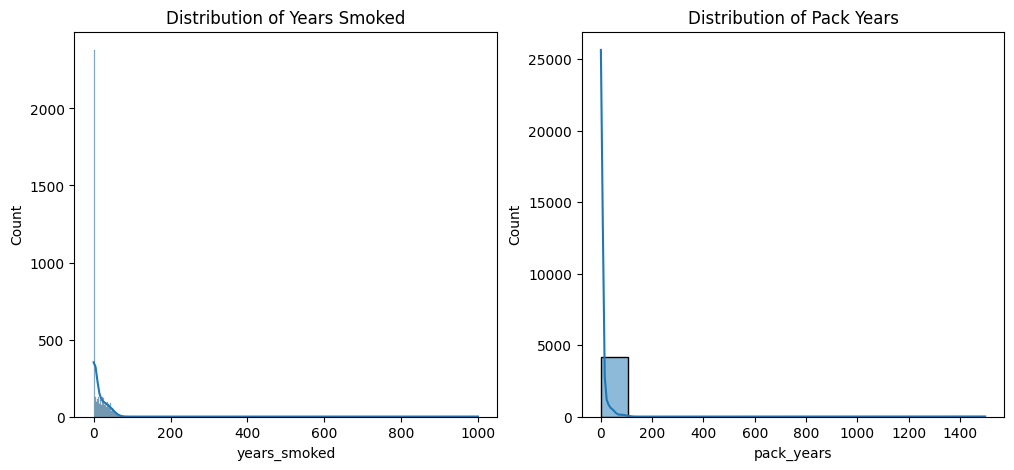

years_smoked    19.279019
pack_years      35.265555
PERMTH_INT      -1.727069
dtype: float64
log_pack_years      2.286123
log_years_smoked    0.500961
dtype: float64


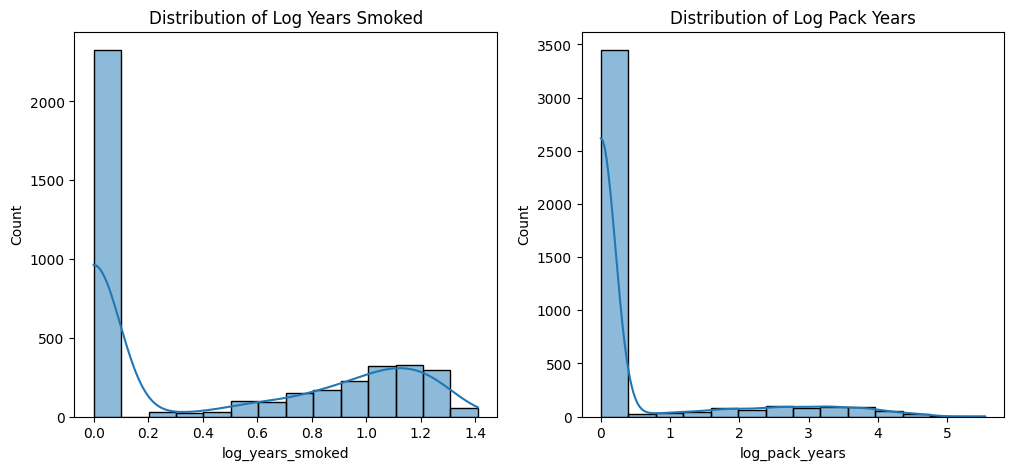

log_years_smoked    0.500961
log_pack_years      2.286123
PERMTH_INT         -1.728693
dtype: float64


In [16]:
# CHECK FOR SKEWEDNESS

import seaborn as sns
import matplotlib.pyplot as plt




# INITIAL SKEW

# 1. Distribution and Skewness
# Visualizing distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df_bp_final['years_smoked'], kde=True, ax=axes[0])
axes[0].set_title('Distribution of Years Smoked')

sns.histplot(df_bp_final['pack_years'], kde=True, ax=axes[1])
axes[1].set_title('Distribution of Pack Years')

plt.show()

# Check numerical skewness (Values > 1 indicate high skew)
print(df_bp_final[['years_smoked', 'pack_years', 'PERMTH_INT']].skew())





#------------------------------------------------------------------------------------------------------------------------

# FIX!




# FILTERING

# Cap years_smoked at a reasonable human limit (e.g., 90 years)
# and pack_years at a reasonable max (e.g., 150-200)
df_bp_final = df_bp_final[df_bp_final['years_smoked'] < 100]
df_bp_final = df_bp_final[df_bp_final['pack_years'] < 300]





# LOG TRANSFORMATION

# Add 1 because log(0) is undefined
df_bp_final['log_pack_years'] = np.log1p(df_bp_final['pack_years'])
df_bp_final['log_years_smoked'] = np.log1p(df_bp_final['years_smoked'])

print(df_bp_final[['log_pack_years', 'log_years_smoked']].skew())




# ROBUST SCALING

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
# Scale your features before putting them into the KNN
cols_to_scale = ['log_pack_years', 'log_years_smoked', 'RIDAGEYR']
df_bp_final[cols_to_scale] = scaler.fit_transform(df_bp_final[cols_to_scale])





#------------------------------------------------------------------------------------------------------------------------


# RESULTS!


# 1. Distribution and Skewness
# Visualizing distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df_bp_final['log_years_smoked'], kde=True, ax=axes[0])
axes[0].set_title('Distribution of Log Years Smoked')

sns.histplot(df_bp_final['log_pack_years'], kde=True, ax=axes[1])
axes[1].set_title('Distribution of Log Pack Years')

plt.show()

# Check numerical skewness (Values > 1 indicate high skew)
print(df_bp_final[['log_years_smoked', 'log_pack_years', 'PERMTH_INT']].skew())








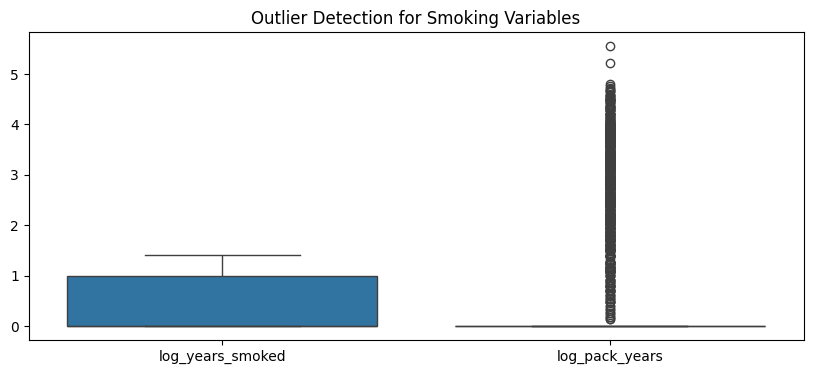

In [17]:
# BOXPLOT FOR OUTLIERS


plt.figure(figsize=(10, 4))
sns.boxplot(data=df_bp_final[['log_years_smoked', 'log_pack_years']])
plt.title('Outlier Detection for Smoking Variables')
plt.show()


# We must move forth with caution and ackowledge that KNN might not be as robust
# at classifying light and heavy smokers compared to non-smokers

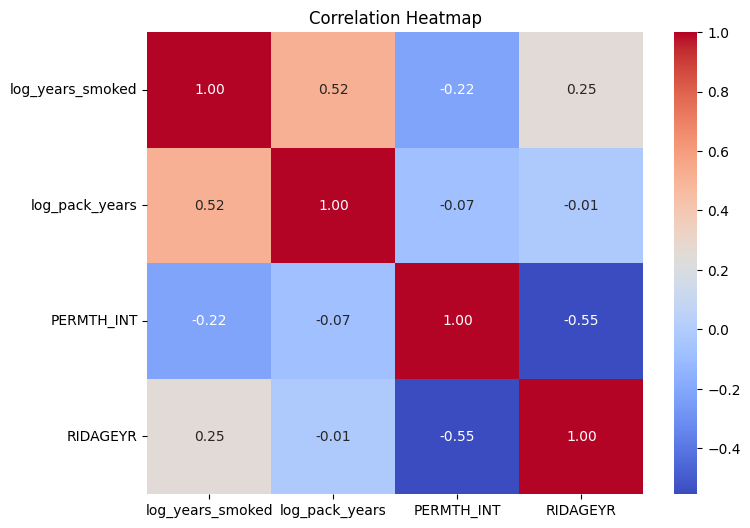

In [18]:
# CORRELATION ANALYSIS

corr_matrix = df_bp_final[['log_years_smoked', 'log_pack_years', 'PERMTH_INT', 'RIDAGEYR']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()



# We will consider running our model twice (once with each variable in order to
# see which is a better predictor of MORTSTAT).

**Final Discussion for EDA:**

**Outliers:** We initially removed extreme values (e.g., years > 100), but significant outliers remain in pack_years due to heavy smokers. These were managed using a log transformation

**Distribution:** The data is highly zero-inflated, as 75% of participants have 0 pack-years. This creates a dense cluster at the origin of our feature space.

**Feature Choice:** Despite the 0.52 correlation between smoking variables, we retained both to see if years_smoked or pack_years provide a more distinct signal for mortality prediction.

Code Source: Gemini

In [19]:
# --- Quick inspection for Part 2 setup ---

# 1) If you're not sure what your final dataframe is called, list variables that look like dataframes
import pandas as pd
candidate_dfs = [
    (name, obj.shape)
    for name, obj in globals().items()
    if isinstance(obj, pd.DataFrame)
]
candidate_dfs_sorted = sorted(candidate_dfs, key=lambda x: x[1][0], reverse=True)
print("DataFrame candidates (largest first):")
for name, shape in candidate_dfs_sorted[:10]:
    print(f"  {name}: {shape}")

# 2) SET THIS to your final merged dataframe name (edit if needed)
# Example: df = final_df
# If your final merged dataframe is already named df, leave as-is.
df  # just to confirm it exists

# 3) Show head + columns
print("\n--- df.head() ---")
display(df.head())

print("\n--- df.columns ---")
print(list(df.columns))

# 4) Try to automatically identify likely mortality + follow-up columns
possible_mortality = [c for c in df.columns if c.upper() in ["MORTSTAT", "MORTALITY", "DEAD", "DIED"]]
possible_followup = [c for c in df.columns if c.upper() in ["PERMTH_EXM", "PERMTH_INT", "FOLLOWUP", "SURVIVAL_MONTHS"]]

print("\n--- Possible mortality columns ---")
print(possible_mortality)

print("\n--- Possible follow-up columns ---")
print(possible_followup)

# 5) If MORTSTAT exists, check its coding
if "MORTSTAT" in df.columns:
    print("\n--- MORTSTAT value counts (including missing) ---")
    print(df["MORTSTAT"].value_counts(dropna=False))

# 6) If PERMTH_EXM / PERMTH_INT exists, summarize
for col in ["PERMTH_EXM", "PERMTH_INT"]:
    if col in df.columns:
        print(f"\n--- {col} summary ---")
        print(df[col].describe())

DataFrame candidates (largest first):
  mdf: (9965, 8)
  gdf: (9965, 144)
  df: (9282, 182)
  blood_pressure: (9282, 32)
  smoking_status: (4880, 39)
  df_adults: (4862, 182)
  df_temp: (4862, 182)
  df_bp_final: (4145, 224)
  _: (5, 182)
  __: (5, 182)

--- df.head() ---


,SEQN,SDDSRVYR,RIDSTATR,RIDEXMON,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDAGEEX,RIDRETH1,RIDRETH2,...,BPXSY3,BPXDI3,BPAEN3,BPXSY4,BPXDI4,BPAEN4,BPXSAR,BPXDAR,systolic_avg,diastolic_avg
0,1.0,1.0,2.0,2.0,2.0,2.0,29.0,31.0,4.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,1.0,2.0,2.0,1.0,77.0,926.0,926.0,3.0,1.0,...,98.0,56.0,2.0,NaN,NaN,NaN,98.0,56.0,100.666667,56.666667
2,3.0,1.0,2.0,1.0,2.0,10.0,125.0,126.0,3.0,1.0,...,112.0,62.0,2.0,NaN,NaN,NaN,108.0,63.0,108.666667,62.000000
3,4.0,1.0,2.0,2.0,1.0,1.0,22.0,23.0,4.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,1.0,2.0,2.0,1.0,49.0,597.0,597.0,3.0,1.0,...,122.0,82.0,2.0,NaN,NaN,NaN,122.0,83.0,122.000000,82.666667



--- df.columns ---
['SEQN', 'SDDSRVYR', 'RIDSTATR', 'RIDEXMON', 'RIAGENDR', 'RIDAGEYR', 'RIDAGEMN', 'RIDAGEEX', 'RIDRETH1', 'RIDRETH2', 'DMQMILIT', 'DMDBORN', 'DMDCITZN', 'DMDYRSUS', 'DMDEDUC3', 'DMDEDUC2', 'DMDEDUC', 'DMDSCHOL', 'DMDMARTL', 'DMDHHSIZ', 'INDHHINC', 'INDFMINC', 'INDFMPIR', 'RIDEXPRG', 'RIDPREG', 'DMDHRGND', 'DMDHRAGE', 'DMDHRBRN', 'DMDHREDU', 'DMDHRMAR', 'DMDHSEDU', 'WTINT2YR', 'WTINT4YR', 'WTMEC2YR', 'WTMEC4YR', 'SDMVPSU', 'SDMVSTRA', 'SDJ1REPN', 'DMAETHN', 'DMARACE', 'WTMREP01', 'WTMREP02', 'WTMREP03', 'WTMREP04', 'WTMREP05', 'WTMREP06', 'WTMREP07', 'WTMREP08', 'WTMREP09', 'WTMREP10', 'WTMREP11', 'WTMREP12', 'WTMREP13', 'WTMREP14', 'WTMREP15', 'WTMREP16', 'WTMREP17', 'WTMREP18', 'WTMREP19', 'WTMREP20', 'WTMREP21', 'WTMREP22', 'WTMREP23', 'WTMREP24', 'WTMREP25', 'WTMREP26', 'WTMREP27', 'WTMREP28', 'WTMREP29', 'WTMREP30', 'WTMREP31', 'WTMREP32', 'WTMREP33', 'WTMREP34', 'WTMREP35', 'WTMREP36', 'WTMREP37', 'WTMREP38', 'WTMREP39', 'WTMREP40', 'WTMREP41', 'WTMREP42', 'WTMR

Part 2: k-NN classification/regression, write-up (50/100 pts)

Submit a notebook that clearly addresses the following, using code and markdown chunks:

1. Describe the data, particularly what an observation is and whether there are any missing data that might impact your analysis. Who collected the data and why? What known limitations are there to analysis? (10/100 pts)

2. Describe the variables you selected to predict mortality and life expectancy, and the rationale behind them. Analyze your variables using describe tables, kernel densities, scatter plots, and conditional kernel densities. Are there any patterns of interest to notice? (10/100 pts)

3. Using your variables to predict mortality using a -Nearest Neighbor Classifier. Analyze its performance and explain clearly how you select . (10/100 pts)

**1.**

Each observation represents one NHANES participant, which is uniquely identified by the variable SEQN. Our dataset has various demographic variables like smoking status, blood pressure results, and linked morality information. We know that each row correspons to a single person because SEQN appears once per row and does not have any duplicates.

There is meaningful missing data that may impact our analysis. Specifically, the morality variable MORTSTAT has quite a bit of missing values. One could probably assume that based on this, it is related to individuals who aren't eligible for morality linkage. Furthermore, there are some follow-up variables and blood pressure stats that are missing. This can impact our analysis because k-nearest neighbors require complete data to compute distances. So, if rows have missing values it will have to be removed and this will reduce our sample size and affect the model as a whole.

The data was collected by the NHANES or National Health and Nutrition Examination Survey from 1999-2000. This survey is conducted by the CDC through the National Center for Health Statistics. It is used to assess US population health and uses a lot of data sources to monitor health trends and use the data to inform policy decision.

There are a couple of limitations that come to mind with this analysis. NHANES data is observational survey datam which means that the relationships that we can identify are not causal, but associative. To add to this, the survey uses a super complex sampling system with strata and weights. But it is important to point out that the k-NN model doesn't account for weights. Lastly, morality status is measured by follow up binary outcomes based on a fixed end date. This doesn't really model censoring or survival time.

In [20]:
print("Shape of dataset (rows, columns):", df.shape)

display(df.head())

print("\nColumn names:")
print(df.columns.tolist())

Shape of dataset (rows, columns): (9282, 182)


,SEQN,SDDSRVYR,RIDSTATR,RIDEXMON,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDAGEEX,RIDRETH1,RIDRETH2,...,BPXSY3,BPXDI3,BPAEN3,BPXSY4,BPXDI4,BPAEN4,BPXSAR,BPXDAR,systolic_avg,diastolic_avg
0,1.0,1.0,2.0,2.0,2.0,2.0,29.0,31.0,4.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,1.0,2.0,2.0,1.0,77.0,926.0,926.0,3.0,1.0,...,98.0,56.0,2.0,NaN,NaN,NaN,98.0,56.0,100.666667,56.666667
2,3.0,1.0,2.0,1.0,2.0,10.0,125.0,126.0,3.0,1.0,...,112.0,62.0,2.0,NaN,NaN,NaN,108.0,63.0,108.666667,62.000000
3,4.0,1.0,2.0,2.0,1.0,1.0,22.0,23.0,4.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,1.0,2.0,2.0,1.0,49.0,597.0,597.0,3.0,1.0,...,122.0,82.0,2.0,NaN,NaN,NaN,122.0,83.0,122.000000,82.666667



Column names:
['SEQN', 'SDDSRVYR', 'RIDSTATR', 'RIDEXMON', 'RIAGENDR', 'RIDAGEYR', 'RIDAGEMN', 'RIDAGEEX', 'RIDRETH1', 'RIDRETH2', 'DMQMILIT', 'DMDBORN', 'DMDCITZN', 'DMDYRSUS', 'DMDEDUC3', 'DMDEDUC2', 'DMDEDUC', 'DMDSCHOL', 'DMDMARTL', 'DMDHHSIZ', 'INDHHINC', 'INDFMINC', 'INDFMPIR', 'RIDEXPRG', 'RIDPREG', 'DMDHRGND', 'DMDHRAGE', 'DMDHRBRN', 'DMDHREDU', 'DMDHRMAR', 'DMDHSEDU', 'WTINT2YR', 'WTINT4YR', 'WTMEC2YR', 'WTMEC4YR', 'SDMVPSU', 'SDMVSTRA', 'SDJ1REPN', 'DMAETHN', 'DMARACE', 'WTMREP01', 'WTMREP02', 'WTMREP03', 'WTMREP04', 'WTMREP05', 'WTMREP06', 'WTMREP07', 'WTMREP08', 'WTMREP09', 'WTMREP10', 'WTMREP11', 'WTMREP12', 'WTMREP13', 'WTMREP14', 'WTMREP15', 'WTMREP16', 'WTMREP17', 'WTMREP18', 'WTMREP19', 'WTMREP20', 'WTMREP21', 'WTMREP22', 'WTMREP23', 'WTMREP24', 'WTMREP25', 'WTMREP26', 'WTMREP27', 'WTMREP28', 'WTMREP29', 'WTMREP30', 'WTMREP31', 'WTMREP32', 'WTMREP33', 'WTMREP34', 'WTMREP35', 'WTMREP36', 'WTMREP37', 'WTMREP38', 'WTMREP39', 'WTMREP40', 'WTMREP41', 'WTMREP42', 'WTMREP43'

In [21]:
print("Number of unique SEQN values:", df["SEQN"].nunique())
print("Total rows:", df.shape[0])
print("Any duplicated SEQN values?", df["SEQN"].duplicated().any())

Number of unique SEQN values: 9282
Total rows: 9282
Any duplicated SEQN values? False


In [22]:
missing = df.isna().mean().sort_values(ascending=False)
display(missing.head(20).to_frame("Missing Rate"))

key_vars = ["MORTSTAT", "PERMTH_EXM", "PERMTH_INT",
            "RIDAGEYR", "systolic_avg", "diastolic_avg"]

print("\nMissingness in key variables:")
display(df[key_vars].isna().mean().to_frame("Missing Rate"))
print("\nMORTSTAT distribution:")
print(df["MORTSTAT"].value_counts(dropna=False))

,Missing Rate
DMAETHN,1.000000
DMARACE,1.000000
BPXDB,0.993859
HYPERTEN,0.843353
DIABETES,0.843353
UCOD_LEADING,0.843353
BPXDI4,0.822991
BPXSY4,0.822991
BPXCHR,0.812109
DMDYRSUS,0.810170



Missingness in key variables:


,Missing Rate
MORTSTAT,0.464232
PERMTH_EXM,0.464232
PERMTH_INT,0.464232
RIDAGEYR,0.000000
systolic_avg,0.225382
diastolic_avg,0.225382



MORTSTAT distribution:
MORTSTAT
NaN    4309
0.0    3519
1.0    1454
Name: count, dtype: int64


**2.**


In order to predict morality and life expectancy, we selected age (RIDAGEYR), sex (RIAGENDR), follow-up time in months (PERMTH_EXM),average diastolic blood pressure (diastolic_avg), and average systolic blood pressure (systolic_avg). We picked these variables for a couple of reasons. Age, is an obvious one, it is strongly associated with morality risks. As age increases so does your probability of death. Sex was picked to see morality pattersn between males and females. Follow-up time in months was inclduded because it is a good proxy for life expentancy if you think about it intuitively. If a deceased individual has a shorter follow up time, it can be due to earlier death. And for the last variable, blood pressure, we added this because it accesses cardiovascular risk, with increased systolic/diastolic levels increasing your risk for death.

Our tables, kernel densities, scatter plots, and conditional kernel densities have a couple of interesting patterns. One, it shows that individuals who died or MORTSTAT equalling 1, are usually older on average compared to those who survived. Our Kernal Density plots show that age distribution for deceased individuals is to the right relative to survivors. The Conditional Kernel Density Plots show a large contrast or seperation in age distributions by morality status. We believe this suggests that age is a strong predictor or death. Our blood pressure distributions do not show a noteable overlap over the differences between groups. We believe that this indicates that blood pressure isn't really a strong predictor in comparison to age. Our scatter plots show that blood pressure by itself does not create a proper seperation between alive and deceased individuals, even as age increases with death probability. In summary, we believe age is the strongest predictor of morality and blood pressure can add to this, but not much.

**Code for Removing Missing Morality and Creating Analysis DataSet**

In [23]:
df_mort = df[df["MORTSTAT"].notna()].copy()
df_mort["MORTSTAT"] = df_mort["MORTSTAT"].astype(int)

vars_selected = ["RIDAGEYR", "RIAGENDR", "systolic_avg",
                 "diastolic_avg", "PERMTH_EXM", "MORTSTAT"]

df_analysis = df_mort[vars_selected].dropna()

print("Analysis dataset shape:", df_analysis.shape)
display(df_analysis.head())

Analysis dataset shape: (4790, 6)


,RIDAGEYR,RIAGENDR,systolic_avg,diastolic_avg,PERMTH_EXM,MORTSTAT
1,77.0,1.0,100.666667,56.666667,177.0,1
4,49.0,1.0,122.000000,82.666667,244.0,0
5,19.0,2.0,114.666667,68.000000,245.0,0
6,59.0,2.0,125.333333,80.000000,236.0,0
9,43.0,1.0,145.333333,96.000000,231.0,1


**Code for Describing Tables**

In [24]:
print("Overall descriptive statistics:")
display(df_analysis.describe())

print("\nDescriptive statistics by mortality status:")
display(df_analysis.groupby("MORTSTAT").describe())

Overall descriptive statistics:


,RIDAGEYR,RIAGENDR,systolic_avg,diastolic_avg,PERMTH_EXM,MORTSTAT
count,4790.000000,4790.000000,4790.000000,4.790000e+03,4790.000000,4790.000000
mean,46.545720,1.526096,126.164231,7.016117e+01,205.198121,0.290814
std,20.272519,0.499371,21.583261,1.469994e+01,63.449901,0.454185
min,18.000000,1.000000,73.000000,5.397605e-79,1.000000,0.000000
25%,28.000000,1.000000,110.666667,6.333333e+01,209.000000,0.000000
50%,45.000000,2.000000,122.000000,7.066667e+01,234.000000,0.000000
75%,64.000000,2.000000,137.000000,7.866667e+01,242.000000,1.000000
max,85.000000,2.000000,231.333333,1.300000e+02,249.000000,1.000000



Descriptive statistics by mortality status:


RIDAGEYR                                                      \
            count       mean        std   min   25%   50%   75%   max   
MORTSTAT                                                                
0          3397.0  38.079482  15.760301  18.0  24.0  36.0  50.0  85.0   
1          1393.0  67.191673  14.368304  18.0  61.0  70.0  78.0  85.0   

         RIAGENDR            ... diastolic_avg             PERMTH_EXM  \
            count      mean  ...           75%         max      count   
MORTSTAT                     ...                                        
0          3397.0  1.553429  ...     78.666667  130.000000     3397.0   
1          1393.0  1.459440  ...     78.000000  120.666667     1393.0   

                                                                    
                mean        std    min    25%    50%    75%    max  
MORTSTAT                                                            
0         238.407713   6.142888  226.0  233.0  239.0  244.0  249.0  
1         124.212491  67.109530    1.0   68.0  122.0  181.0  247.0  

[2 rows x 40 columns]

**Code for Density Plots**

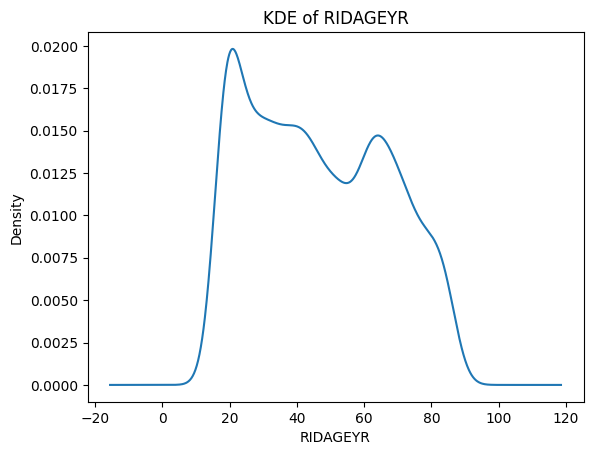

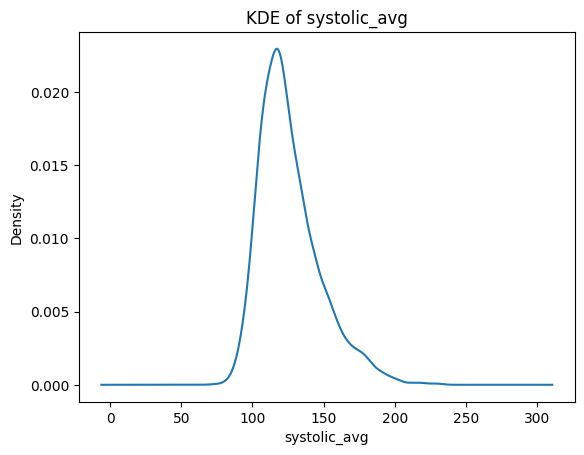

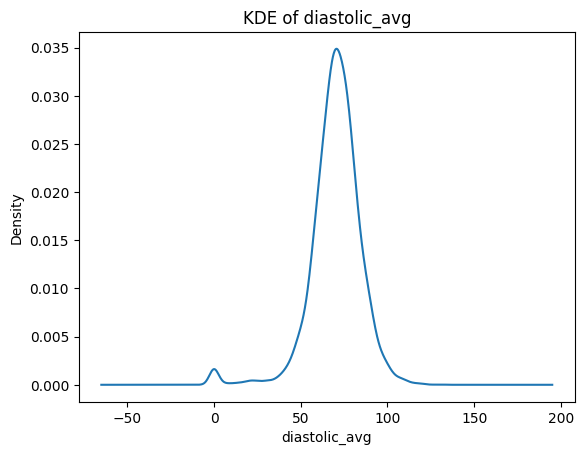

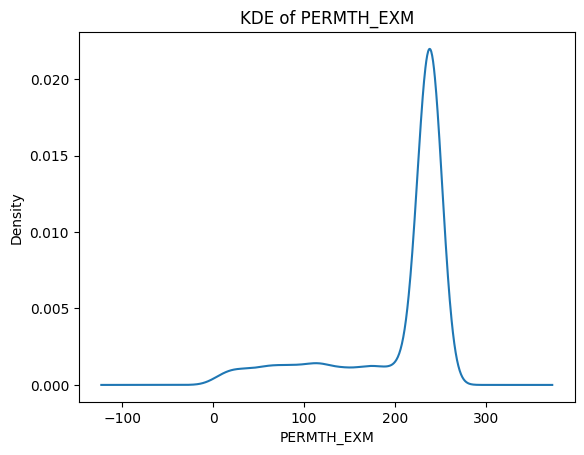

In [25]:
import matplotlib.pyplot as plt

numeric_vars = ["RIDAGEYR", "systolic_avg", "diastolic_avg", "PERMTH_EXM"]

for col in numeric_vars:
    plt.figure()
    df_analysis[col].plot(kind="kde")
    plt.title(f"KDE of {col}")
    plt.xlabel(col)
    plt.show()

**Code for Conditional by Morality Plots**

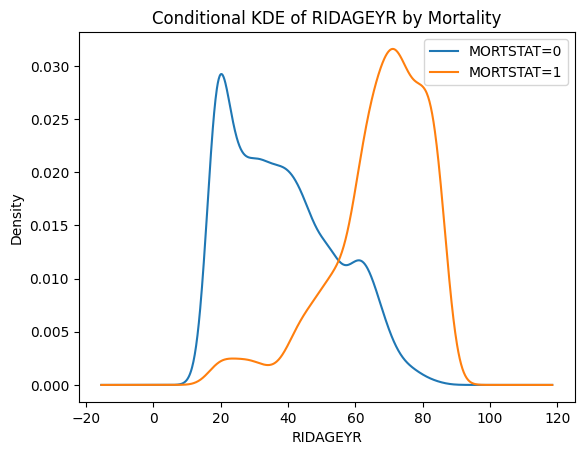

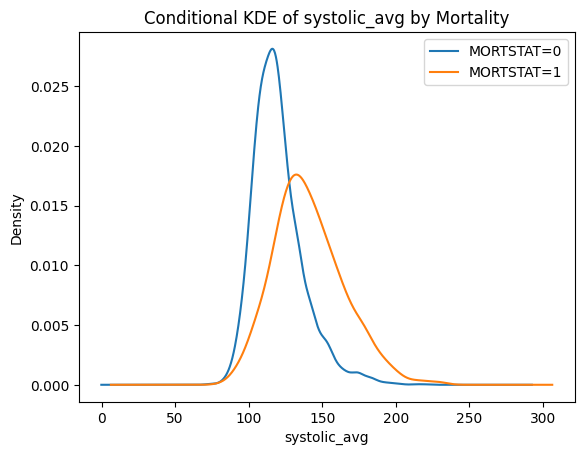

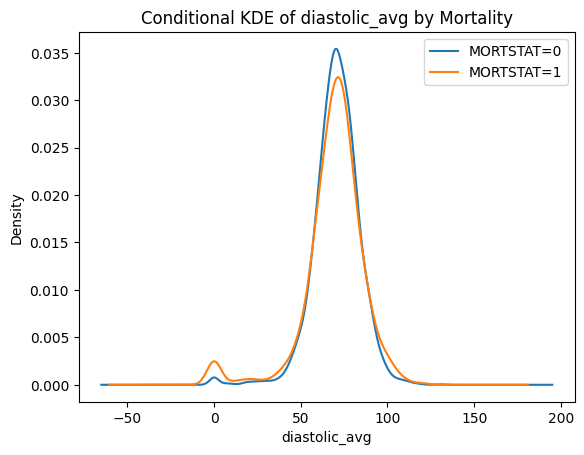

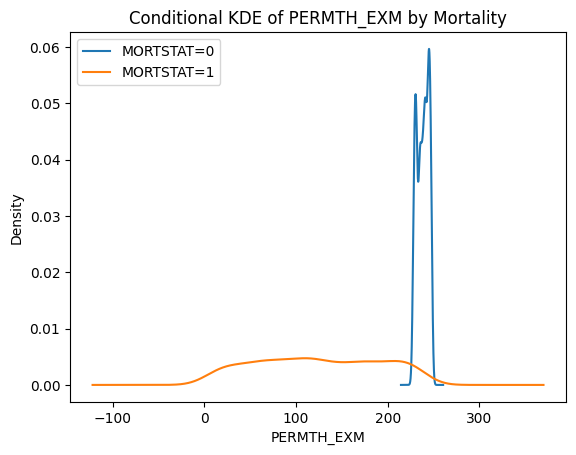

In [26]:
for col in numeric_vars:
    plt.figure()
    for m in [0, 1]:
        df_analysis[df_analysis["MORTSTAT"] == m][col].plot(kind="kde", label=f"MORTSTAT={m}")
    plt.title(f"Conditional KDE of {col} by Mortality")
    plt.xlabel(col)
    plt.legend()
    plt.show()

**Code for Scatterplots with Morality Seperation**

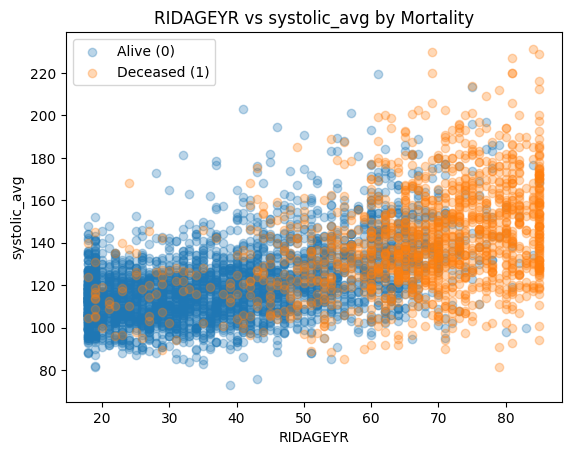

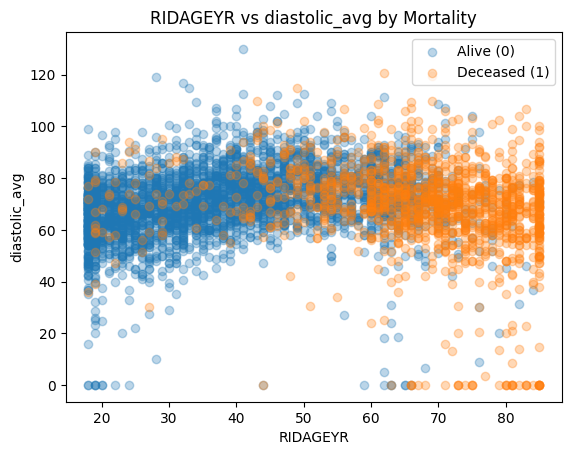

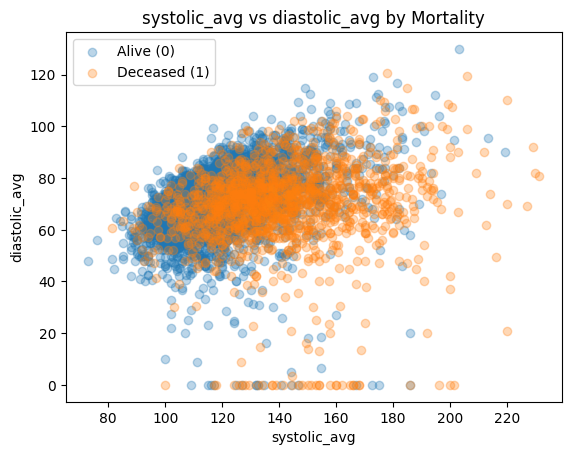

In [27]:
def scatter_plot(x, y):
    plt.figure()
    alive = df_analysis[df_analysis["MORTSTAT"] == 0]
    dead = df_analysis[df_analysis["MORTSTAT"] == 1]

    plt.scatter(alive[x], alive[y], alpha=0.3, label="Alive (0)")
    plt.scatter(dead[x], dead[y], alpha=0.3, label="Deceased (1)")

    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f"{x} vs {y} by Mortality")
    plt.legend()
    plt.show()

scatter_plot("RIDAGEYR", "systolic_avg")
scatter_plot("RIDAGEYR", "diastolic_avg")
scatter_plot("systolic_avg", "diastolic_avg")

**3.**

In order for us to predict mortality, we used a k-Nearest Neighbor classifier with average systolic blood pressure, average diastolic blood pressure, sex, and age as our predictors. We did this because our predictors were standardized using StandardScaler to make sure that variables that might be measured on different scales like age and blood pressure, were not improperly influencing the distance calculation that is k-NN.

In order to select the optimal number of k neighbors, we looked at odd values that lied between 3 and 39 using cross validation on our training set. We selected the the k value that maximized mean cross-validated accuracy for the optimal model. With this approach in mind, we were able to balance variance and bias. We know this because k values can overfit data and larger values can underfit.

Our final model though, was evaluated on a held out test set where performance was evaluated using accuracy and a classification report. Our results showed that the model can perform well in prediciting survival status. It also shows that age firmly contributes to classification performance. But, we did notice some overlap that limits perfect seperation. For example, similar blood pressure values among those who are deceased and alive. But overall, the model does exhibit the ability to predict mortality, with age being our strongest predictor.

In [28]:
df_mort = df[df["MORTSTAT"].notna()].copy()
df_mort["MORTSTAT"] = df_mort["MORTSTAT"].astype(int)

features = ["RIDAGEYR", "RIAGENDR", "systolic_avg", "diastolic_avg"]

df_model = df_mort[features + ["MORTSTAT"]].dropna()

X = df_model[features]
y = df_model["MORTSTAT"]

print("Model dataset shape:", df_model.shape)
print("Class distribution:")
print(y.value_counts(normalize=True))

Model dataset shape: (4790, 5)
Class distribution:
MORTSTAT
0    0.709186
1    0.290814
Name: proportion, dtype: float64


In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

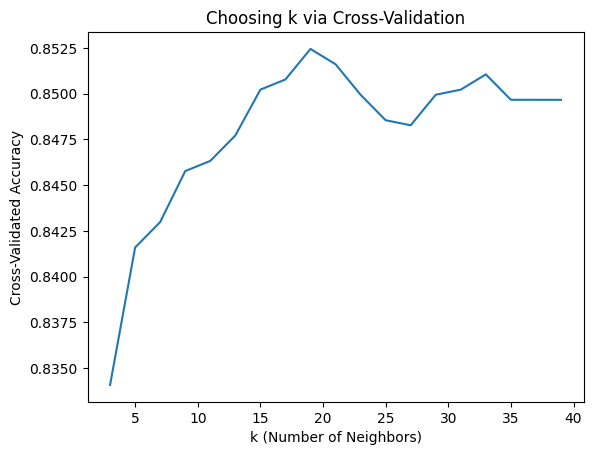

Best k: 19
Best CV accuracy: 0.8524482703848195


In [30]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt

k_values = range(3, 41, 2)
cv_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring="accuracy")
    cv_scores.append(scores.mean())

plt.figure()
plt.plot(k_values, cv_scores)
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("Cross-Validated Accuracy")
plt.title("Choosing k via Cross-Validation")
plt.show()

best_k = k_values[np.argmax(cv_scores)]
print("Best k:", best_k)
print("Best CV accuracy:", max(cv_scores))

In [31]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(X_train_scaled, y_train)

y_pred = knn_final.predict(X_test_scaled)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.8580968280467446

Confusion Matrix:
[[781  69]
 [101 247]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90       850
           1       0.78      0.71      0.74       348

    accuracy                           0.86      1198
   macro avg       0.83      0.81      0.82      1198
weighted avg       0.86      0.86      0.86      1198



**4.**

In [34]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Features to use for predicting life expectancy
feature_cols = ['RIDAGEEX', 'RIAGENDR', 'RIDRETH1', 'INDFMPIR',
                'systolic_avg', 'diastolic_avg', 'BPXPLS', 'DIABETES', 'HYPERTEN']

# Only use deceased individuals with valid survival time
reg_df = df[df['MORTSTAT'] == 1].dropna(subset=feature_cols + ['PERMTH_INT'])

X = reg_df[feature_cols]
y = reg_df['PERMTH_INT']

print(f"Samples available for regression: {len(reg_df)}")

Samples available for regression: 1069


In [35]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

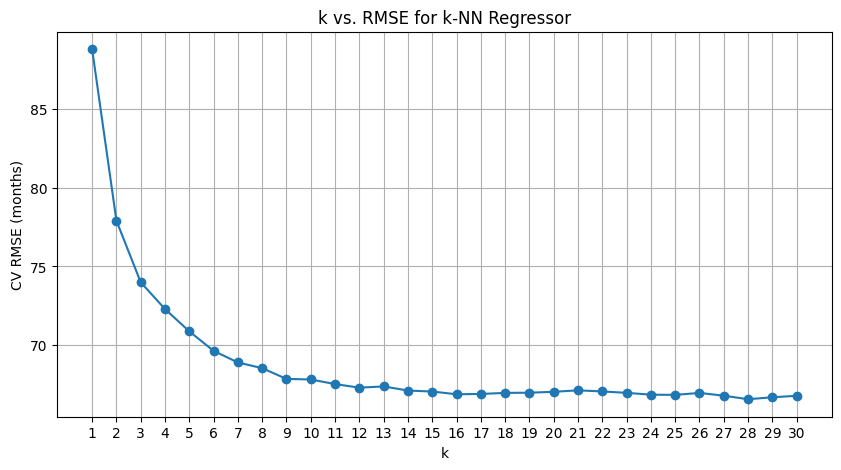

Best k: 28 with CV RMSE: 66.54 months


In [36]:
k_range = range(1, 31)
rmse_scores = []

for k in k_range:
    model = KNeighborsRegressor(n_neighbors=k)
    scores = cross_val_score(model, X_train, y_train, cv=5,
                             scoring='neg_root_mean_squared_error')
    rmse_scores.append(-scores.mean())

plt.figure(figsize=(10, 5))
plt.plot(k_range, rmse_scores, marker='o')
plt.xlabel('k')
plt.ylabel('CV RMSE (months)')
plt.title('k vs. RMSE for k-NN Regressor')
plt.xticks(range(1, 31))
plt.grid(True)
plt.show()

best_k = list(k_range)[np.argmin(rmse_scores)]
print(f"Best k: {best_k} with CV RMSE: {min(rmse_scores):.2f} months")

Test RMSE: 64.75 months (5.4 years)


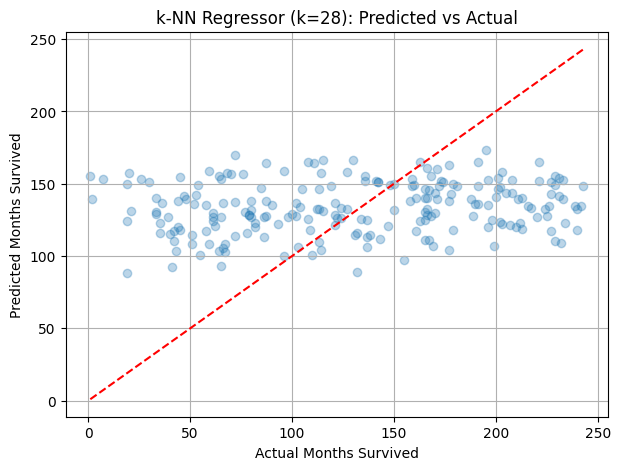

In [39]:
final_model = KNeighborsRegressor(n_neighbors=best_k)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {test_rmse:.2f} months ({test_rmse/12:.1f} years)")

# Plot predicted vs actual
plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Months Survived')
plt.ylabel('Predicted Months Survived')
plt.title(f'k-NN Regressor (k={best_k}): Predicted vs Actual')
plt.grid(True)
plt.show()

**Q4**: k-NN Regression for Life Expectancy

We predict `PERMTH_INT` (months from interview to death) using k-NN regression,
restricted to deceased individuals (`MORTSTAT == 1`), giving us 1,069 samples.

**Features used:** age at exam, sex, race/ethnicity, income-to-poverty ratio,
average systolic/diastolic blood pressure, pulse rate, diabetes, and hypertension — all standardized using StandardScaler.

**Selecting k:** We tested k=1 through 30 using 5-fold cross-validation. The RMSE curve drops steeply from k=1 and flattens out around k=20+, with k=28 minimizing CV RMSE at 66.54 months. The flat tail suggests the model is stable at higher k values, and a large k makes sense here given the modest sample size (1,069). Therefore, small k would overfit to noisy individual survival times.

**Performance:** Test RMSE was 64.75 months (5.4 years). The predicted vs. actual plot shows the model captures the general upward trend but struggles with extreme values, with predictions clustering around 100–150 months regardless of actual survival time.
This is expected behavior for k-NN regression, which averages neighbors and therefore pulls predictions toward the mean, underestimating very short and very long survival times.